# Updates as of Septemeber 5
Added sparse hamiltonian functionality

#Updates
1. **Non sequential hopping correction**  

Issue Resolved: 

The issue is that the creation and annihilation operators must obey anti-commutation relations in order to account for the exchange asymmetry due to the fact that electrons are fermions. For the linear lattice case, the hopping is only between neighboring qubits and this isn’t an issue and we have 
$$a_i^\dagger a_j + a_j^\dagger a_i = \frac{1}{2}(X_iX_j + Y_iY_j)$$

However if the hopping is between two qubit that are not adjacent as will be the case for hopping between qubit 0 and and qubit 3 then a Z gate for each of the intermediate qubits is needed
$$a_i^\dagger a_j + a_j^\dagger a_i = \frac{1}{2}(X_iX_j + Y_iY_j)Z_{i+1}...Z_{j-1}$$

2. **Coulomb Term Calculation**
Implemented by Prof. Schnetzer


## Changes as of March 27, 2022
1. Can do 1xn or nx1 lattices with arbitrary number so spin up and spin down 
2. Ground State is shown in first line
3. No long decimal values shown for eigen states
4. Technical detail: No longer using reduced hamiltonian

In [9]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt


IndentationError: unexpected indent (version.py, line 2)

## Building Lattice

In [ ]:
def lattice(rows, cols):
  '''
  Given num of rows , cols, builds a graph
  '''
  #taking care of vertices
  n = rows*cols   # number of vertices
  vertices = [i for i in range(n)]
  G = nx.Graph()
  G.add_nodes_from(vertices)

  #taking care of edges
  for i in range(rows):

    #last row]
    if i == rows-1:
      for j in range(cols):
        #not last vertex of row
        if j != cols-1:
          # print('last row, last column')
          # print(i)
          # print(j)
          # print(i*rows +j)
          G.add_edge(i*cols +j, (i)*cols +j+1) #horizontal
    #not last row
    else:
      for j in range(cols):
        #last vertex of row
        if j == cols-1:
          G.add_edge(i*cols +j, (i+1)*cols +j) #vertical
        else:
          G.add_edge(i*cols +j, (i+1)*cols +j) #vertical
          G.add_edge(i*cols +j, (i)*cols +j+1) #horizontal
  return G



In [ ]:
G = lattice(1,4)
nx.draw(G, with_labels=True )

## Helper Functions

In [ ]:
def pad0s(bin_string, padding):
    '''
    Input: Append 0's to font so len(bin_string) = padding
    '''
    while (len(bin_string) != padding):
        bin_string = '0'+bin_string
    return bin_string
        
def decimalToBinary(n):
    #convert decimal number to binary 
    bin_string = ''
    if n  ==0:
        return '0'
    while (n>1):
        bin_string = str(n%2) + bin_string
        n = int(n/2)
    if n == 1:
        bin_string = str(1) + bin_string
    return bin_string
    
def binaryToDecimal(bin_string):
    #convert ninary number to binay
    n = len(bin_string)
    num = 0
    for i in range(n):
        num+=int(bin_string[n-1-i])*(2**(i))
    
    return num

def generate_state(bin_string):
    '''
    Given a bin string, generates a state vector
    '''
    n = binaryToDecimal(bin_string)
    l = len(bin_string)
    state = np.zeros((2**l,1))
    state[n] = 1
    return state
def ket_rep(state):
    '''
    Given a vector, changes into ket notation
    '''
    n = len(state)
    string = ''
    for j in range(n):
        if state[j] !=0 :
            stringy = str(np.round(float(state[j]),3))+ "|"+(pad0s(decimalToBinary(j), np.log2(n)))+">  + "
            string+= stringy
    return string

def numberOf1s(bin_string):
    '''
    Input: Given a binary number, this function tells how many 1's in it
    '''
    n = len(bin_string)
    counter = 0
    for i in range(n):
        if bin_string[i] == '1':
            counter+=1
    return counter

def isLegal(bin_string, p_up, p_down):
  '''
  A state is illegal if number of particles in first half are not p_up and that in second hald are not p_down
  '''
  n = len(bin_string)

  #First Half
  check = 0
  for i in range(0, int(n/2)):
    if bin_string[i] == '1':
      check+=1
  if check!=int(p_up):
    return False
  
  #Second Half
  check = 0
  for i in range(int(n/2), n):
    if bin_string[i] == '1':
      check+=1
  if check!=int(p_down):
    return False
  return True


def isModeFilled(bin_string, i):
    '''
    Input: given a binary string, return true if the i'th index from the right is filled or not
    '''
    n = len(bin_string)
    if bin_string[n-i-1] =='1':
        return True
    return False

def applyHoppingOperator(bin_string, x,y , hamiltonian, t):
    '''
    Input: given a binary string, applies a_y^dagger a_x
    Returns modified hamiltonian
    '''
    
    n = len(bin_string)
    initial = bin_string
    final = initial
    #----------------------for non sequential hops edit Aug 12
    n_intermed = 0
    if np.abs(x-y) !=1 : #x,y not sequential
      large = max(x,y)
      small = min(x, y)
      middle = small + 1
      while middle != large: 
        if isModeFilled(initial, middle):
          n_intermed+=1
        middle+=1
      #endwhile
    #endif
    factor_non_seq = (-1)**n_intermed
    #------------------------------------------------------------

    
    if (isModeFilled(initial, x) is True) and (isModeFilled(initial, y) is False):
        #satisfying above conditions means some element of hamiltonian must be 1
        
        if (x ==0):
            final = final[0:n-1-x] + '0'      # applying a_x (setting the x'th index of initial 0)
        else:
            final = final[0:n-1-x] + '0'+  final[n-x:]
        #print(bin_string)
        if (y ==0):
            final = final[0:n-1-y] + '1' 
        else:
            final = final[0:n-1-y] + '1'+  final[n-y:]
        
        col_index = binaryToDecimal(initial)
        row_index = binaryToDecimal(final)
        hamiltonian[row_index, col_index] = -t*factor_non_seq
    return hamiltonian

In [2]:
#applyHoppingOperator('10111', 0, 4,None,None)

# Main Functions

In [3]:
def getHamiltonian(n, G, p_up, p_down, t = 1, U = 0):
    '''
    
    Input: number of sites n , graph G, number of particles p
    Output: the hamiltonian
    
    '''
    #first generate all basis states (in binary)
    states = [pad0s(decimalToBinary(k), 2*n) for k in range(0,2**(2*n),1)]
    
    #now generate the hamiltonian with all entries set to 0
    matrix = np.zeros((2**(2*n), 2**(2*n)))
    
    #now choose the basis states that are physical (i.e. that have number of 1s = number of particles (p_up + p_down))
    physical_states = []
    for state in states:
        if numberOf1s(state) ==(p_up + p_down):
          if isLegal(state, p_up, p_down):
            physical_states.append(state)
    print("physical states")
    print(len(physical_states))
    #return None
    
    #with these physical states, we now simulate applying the hopping operators (only the first term of hamiltonain)
    for state in physical_states:

        # first apply the a^dagger a terms 
        for edge in G.edges:
          i, j = edge
          # print(edge)
          # print(i)
          # print(j)
          # print('****')

          #spin up 
          ## first a_(j)^\dagger a_i
          matrix = applyHoppingOperator(state, i, j, matrix, t)   
          ## now a_(i)^\dagger a_j    
          matrix = applyHoppingOperator(state, j, i, matrix, t)

          #spin down
          ## first a_(j)^\dagger a_i
          matrix = applyHoppingOperator(state, n+i, n+j, matrix, t)   
          ## now a_(i)^\dagger a_j    
          matrix = applyHoppingOperator(state, n+j, n+i, matrix, t)

        #now comes the coulomb term
        overlap = 0
        for i in range(n):
            if isModeFilled(state, i) and isModeFilled(state, n+i):
              overlap = overlap +1
        if(overlap != 0):
            index = binaryToDecimal(state)
            matrix[index, index] = U*overlap

        
    return matrix
    

In [4]:
import scipy 

def get_eigenvectors_eigenvalues(rows, cols, p_up, p_down, U, t, do_sparse = False, num_eigs = 6):
  '''
  Given rows, cols, number of particles p, U and t of a lattice, outputs its eigenvectors and eigenvalues;
  dosparse is boolean which evaluates eigenvalues of sparse hamiltonian if true
  num_eigs is desired num of eigenvalues (only sensical if do_sparse is true)
  '''
  G = lattice(rows, cols)
  nx.draw(G, with_labels=True)
  plt.show()
  n = rows*cols 
  hammy = getHamiltonian(n, G, p_up, p_down, t, U)
  
  from scipy.sparse import linalg as sparse_linalg
  from scipy import linalg

  physical_states = {}
  physical_states_index = {}
  i = 0
  num = 0
  for k in range(0,2**(2*n)):
    state = pad0s(decimalToBinary(k), 2*n)
    if isLegal(state, p_up, p_down) and (numberOf1s(state) == (p_up+p_down)):
      physical_states[state] = i
      physical_states_index[i] = state
      i+=1
      num+=1
  
  #reduce the matrix
  # reduced_hammy = np.zeros((num, num))
  # for row in range(num):
  #   for col in range(num):
  #     true_row = binaryToDecimal(physical_states_index[row])
  #     true_col = binaryToDecimal(physical_states_index[col])
  #     reduced_hammy[row, col] = hammy[true_row, true_col]
    



  
  if do_sparse: 
      w, v = sparse_linalg.eigs(hammy, k = num_eigs )
      print('Ground State Energy is ' + str(min(w)))
      print('All (acc to number of eigvals specified) Eigvals below')
      print(w)
      print('Associated Eigenvectors')
      print(v)
      #print(len(v[0]))
      return None
   #-------------------------If not sparse -------------------------------------# 
  else: 
    w, v = linalg.eig(hammy)
  v = np.transpose(v)

  #you only need this if you do reduced hammy (because dimension of eigvec of reduced hammy is NOT dim of eig vec of original hammy)
  # v_full = []
  # for vec in v: # vec is eige
  #   new_vec = [0 for i in range(2**(2*n))]
  #   for l in range(num):
  #     if vec[l] != float(0):
  #       new_vec[binaryToDecimal(physical_states_index[l])] = vec[l]
  #   v_full.append(new_vec)

  #for some reason, i have to do this step. IDK why
  # v_full = np.array(v_full)
  # v_full = np.transpose(v_full)

  print('Note: All eigenvalues rounded to 3 decimal places')
  print('*********************************************************************')
  print('Ground State is :')
  index_min = np.argmin(w)
  energy = w[index_min]
  vec = v[index_min]
  print('Eigenvalue: ' + str(energy))
  print('eigenvector is ')
  print(ket_rep(vec))

  print('*********************************************************************')
  print('The hamiltonian is :')
  print(hammy)
  print(v)
  print('---------------------------------')

  print('Eigenvectors and Eigenvalues')
  for n in range(len(w)):
    eig = w[n]
    print('***********************')
    print('Eigenvalue: ' + str(eig))
    print(ket_rep(v[n]))

  return None


# Changes as of March 27, 2022
1. Can do 1xn or nx1 lattices with arbitrary number so spin up and spin down 
2. Ground State is shown in first line
3. No long decimal values shown for eigen states
4. Technical detail: No longer using reduced hamiltonian

# Check : 1x2 Case (1 up 1 down particles)

This check ensures that we get out from new code what we already know from Prof. Schnetzer's calculations

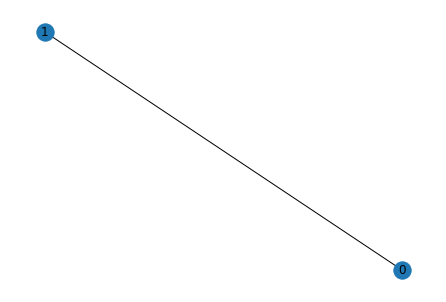

physical states
4
Note: All eigenvalues rounded to 3 decimal places
*********************************************************************
Ground State is :
Eigenvalue: (-1.9999999999999996+0j)
eigenvector is 
-0.5|0101>  + -0.5|0110>  + -0.5|1001>  + -0.5|1010>  + 
*********************************************************************
The hamiltonian is :
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0

In [34]:
hammy = get_eigenvectors_eigenvalues(rows = 1, cols = 2, p_up = 1, p_down = 1, U = 0, t = 1)

# Check : 1x2 Case (1 up 0 down particles)

This check ensures that we get out from new code what we already know from Prof. Schnetzer's calculations

In [30]:
#get_eigenvectors_eigenvalues(rows = 2, cols = 1, p_up = 1, p_down = 0, U = 0, t = 1)

Same but reverse (1x2: 0 up, 1 down)

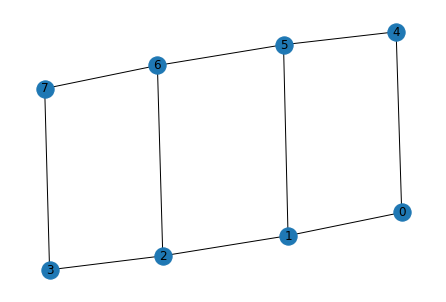

physical states
64
Ground State Energy is (-5.236067977499794+0j)
All (acc to number of eigvals specified) Eigvals below
[-5.23606798+0.j  5.23606798+0.j -4.23606798+0.j -4.23606798+0.j
  4.23606798+0.j  4.23606798+0.j -3.23606798+0.j -3.23606798+0.j]
Associated Eigenvectors
[[ 2.24333716e-19+0.j -1.67079190e-19+0.j  1.24438588e-19+0.j ...
  -1.21352041e-18+0.j -1.66521493e-19+0.j -6.39889809e-21+0.j]
 [ 2.19356857e-19+0.j -1.64327816e-19+0.j  1.23909324e-19+0.j ...
  -1.16794529e-18+0.j -1.54299477e-19+0.j -6.45732834e-21+0.j]
 [-2.25267908e-19+0.j  1.74827090e-19+0.j -1.28085521e-19+0.j ...
   1.32024554e-18+0.j  1.69149901e-19+0.j  6.39044492e-21+0.j]
 ...
 [ 9.89418064e-20+0.j -7.50160443e-20+0.j  5.46104638e-20+0.j ...
  -5.27038633e-19+0.j -7.42153365e-20+0.j -2.88651897e-21+0.j]
 [ 1.14668142e-19+0.j -8.82100250e-20+0.j  6.39929026e-20+0.j ...
  -6.87301358e-19+0.j -8.50334983e-20+0.j -2.96041718e-21+0.j]
 [ 3.07181202e-19+0.j -2.35670164e-19+0.j  1.71754293e-19+0.j ...
  -1.689

In [31]:
get_eigenvectors_eigenvalues(rows = 2, cols = 4, p_up =1, p_down = 1, U = 0, t = 1, do_sparse = True, num_eigs= 8)

In [13]:
from scipy.sparse import linalg

# 2x2

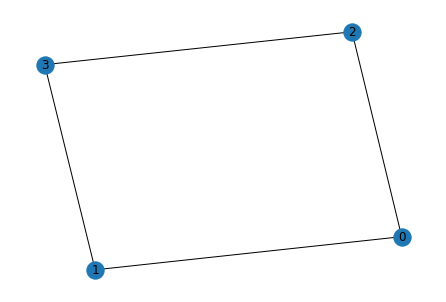

physical states
['00110011', '00110101', '00110110', '00111001', '00111010', '00111100', '01010011', '01010101', '01010110', '01011001', '01011010', '01011100', '01100011', '01100101', '01100110', '01101001', '01101010', '01101100', '10010011', '10010101', '10010110', '10011001', '10011010', '10011100', '10100011', '10100101', '10100110', '10101001', '10101010', '10101100', '11000011', '11000101', '11000110', '11001001', '11001010', '11001100']
Note: All eigenvalues rounded to 3 decimal places
*********************************************************************
Ground State is :
Eigenvalue: (-4.000000000000003+0j)
eigenvector is 
0.169|00110011>  + -0.068|00110101>  + -0.236|00110110>  + 0.101|00111001>  + -0.068|00111010>  + 0.169|00111100>  + 0.066|01010011>  + -0.159|01010101>  + -0.224|01010110>  + -0.093|01011001>  + -0.159|01011010>  + 0.066|01011100>  + -0.103|01100011>  + -0.091|01100101>  + 0.012|01100110>  + -0.194|01101001>  + -0.091|01101010>  + -0.103|01101100>  + 0.234|1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: ComplexWarning: Casting complex values to real discards the imaginary part



1.0|01111101>  + 
***********************
Eigenvalue: 0j
1.0|01111110>  + 
***********************
Eigenvalue: 0j
1.0|01111111>  + 
***********************
Eigenvalue: 0j
1.0|10000000>  + 
***********************
Eigenvalue: 0j
1.0|10000001>  + 
***********************
Eigenvalue: 0j
1.0|10000010>  + 
***********************
Eigenvalue: 0j
1.0|10000011>  + 
***********************
Eigenvalue: 0j
1.0|10000100>  + 
***********************
Eigenvalue: 0j
1.0|10000101>  + 
***********************
Eigenvalue: 0j
1.0|10000110>  + 
***********************
Eigenvalue: 0j
1.0|10000111>  + 
***********************
Eigenvalue: 0j
1.0|10001000>  + 
***********************
Eigenvalue: 0j
1.0|10001001>  + 
***********************
Eigenvalue: 0j
1.0|10001010>  + 
***********************
Eigenvalue: 0j
1.0|10001011>  + 
***********************
Eigenvalue: 0j
1.0|10001100>  + 
***********************
Eigenvalue: 0j
1.0|10001101>  + 
***********************
Eigenvalue: 0j
1.0|10001110>  + 
************

In [ ]:
hammy = get_eigenvectors_eigenvalues(rows = 2, cols = 2, p_up = 2, p_down = 2, U = 0, t = 1)

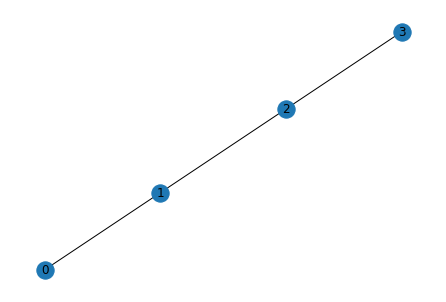

physical states
['00110011', '00110101', '00110110', '00111001', '00111010', '00111100', '01010011', '01010101', '01010110', '01011001', '01011010', '01011100', '01100011', '01100101', '01100110', '01101001', '01101010', '01101100', '10010011', '10010101', '10010110', '10011001', '10011010', '10011100', '10100011', '10100101', '10100110', '10101001', '10101010', '10101100', '11000011', '11000101', '11000110', '11001001', '11001010', '11001100']
Note: All eigenvalues rounded to 3 decimal places
*********************************************************************
Ground State is :
Eigenvalue: (-3.5753656204474775+0j)
eigenvector is 
0.032|00110011>  + 0.09|00110101>  + 0.095|00110110>  + 0.095|00111001>  + 0.126|00111010>  + 0.07|00111100>  + 0.09|01010011>  + 0.189|01010101>  + 0.219|01010110>  + 0.219|01011001>  + 0.315|01011010>  + 0.126|01011100>  + 0.095|01100011>  + 0.219|01100101>  + 0.157|01100110>  + 0.245|01101001>  + 0.219|01101010>  + 0.095|01101100>  + 0.095|10010011>  + 0.

In [ ]:
#hammy = get_eigenvectors_eigenvalues(rows = 1, cols = 4, p_up = 2, p_down = 2, U = 1, t = 1)